In [ ]:
import torch
import torch.nn as nn

import pyro
import pyro.distributions as dist
from pyro.infer import MCMC, NUTS

from sklearn.datasets import make_blobs, make_moons
from sklearn.linear_model import LogisticRegression

import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

In [26]:
def compare_measures(m1, m2, name1, name2, ax=None):
    m1 = m1.flatten()
    m2 = m2.flatten()

    correlation = torch.corrcoef(torch.stack((m2, m1)))[0, 1]
    print(f"Correlation between {name1} and {name2}: {correlation.item():.4f}")

    if ax is not None:
        ax.scatter(m1, m2, alpha=0.5, s=5)
        ax.set_xlabel(name1)
        ax.set_ylabel(name2)
        ax.set_title(f"Correlation: {correlation.item():.4f}")

        z = np.polyfit(m1.numpy(), m2.numpy(), 1)
        p = np.poly1d(z)
        x_range = np.linspace(m1.min().item(), m1.max().item(), 100)
        ax.plot(x_range, p(x_range), "r--", alpha=0.8)

    return correlation.item()

In [27]:
class SimpleModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer_1 = nn.Linear(2, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.sigmoid(self.layer_1(x))
        return x

    def get_logits(self, x):
        return self.layer_1(x)

    def parameters_as_vector(self):
        params = []
        for param in self.parameters():
            params.append(param.data.view(-1))
        return torch.cat(params)

    def count_parameters(self):
        return sum(p.numel() for p in self.parameters())

In [28]:
class ComplexModel(nn.Module):
    def __init__(self, hidden_size=32):
        super().__init__()
        self.layer_1 = nn.Linear(2, hidden_size)
        self.layer_2 = nn.Linear(hidden_size, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.sigmoid(self.layer_1(x))
        x = self.sigmoid(self.layer_2(x))
        return x

    def get_logits(self, x):
        x = self.sigmoid(self.layer_1(x))
        return self.layer_2(x)

    def parameters_as_vector(self):
        params = []
        for param in self.parameters():
            params.append(param.data.view(-1))
        return torch.cat(params)

    def count_parameters(self):
        return sum(p.numel() for p in self.parameters())

In [29]:
# Diagonal Hessian approximation using Fisher Information Matrix
def compute_hessian_diagonal(model, data_x, data_y, prior_precision=0.01):
    n_params = model.count_parameters()
    hessian_diag = torch.zeros(n_params)

    for x, y in zip(data_x, data_y):
        x = x.unsqueeze(0)
        model.zero_grad()

        logits = model.get_logits(x)
        prob = torch.sigmoid(logits)

        loss = -torch.log(prob) if y > 0.5 else -torch.log(1 - prob)
        loss.backward()

        grads = []
        for param in model.parameters():
            if param.grad is not None:
                grads.append(param.grad.view(-1))
        grads = torch.cat(grads)

        hessian_diag += grads * grads

    hessian_diag += prior_precision

    return hessian_diag

In [30]:
def laplace_predict(model, x_test, posterior_variance, samples=100):
    n_test = len(x_test)

    all_preds = torch.zeros(samples, n_test)

    map_weights = model.parameters_as_vector()

    for i in range(samples):
        sampled_weights = map_weights + torch.randn_like(map_weights) * torch.sqrt(
            posterior_variance
        )

        idx = 0
        for param in model.parameters():
            param_size = param.numel()
            param.data = sampled_weights[idx : idx + param_size].reshape(param.shape)
            idx += param_size

        with torch.no_grad():
            all_preds[i] = model(x_test).squeeze()

    idx = 0
    for param in model.parameters():
        param_size = param.numel()
        param.data = map_weights[idx : idx + param_size].reshape(param.shape)
        idx += param_size

    pred_mean = all_preds.mean(0)
    pred_var = all_preds.var(0)

    return pred_mean, pred_var

In [31]:
def get_grad_norm(model, loss_fn, x, y):
    model.zero_grad()
    loss = loss_fn(model(x), y)
    loss.backward()

    grads = []
    for name, param in model.named_parameters():
        if param.grad is not None:
            grads.append(param.grad.flatten())

    return torch.norm(torch.cat(grads))

In [32]:
def get_grad_norm_grid(model, loss_fn, samples, permute=lambda x: x):
    viz_grad = []

    for x in samples:
        viz_grad.append(
            get_grad_norm(
                model,
                loss_fn,
                x.reshape(1, -1),
                permute(model(x.reshape(1, -1)).round()),
            )
        )

    return torch.tensor(viz_grad)

In [33]:
def compare_measures(m1, m2, name1, name2, ax=None):
    m1 = m1.flatten()
    m2 = m2.flatten()

    correlation = torch.corrcoef(torch.stack((m2, m1)))[0, 1]
    print(f"Correlation between {name1} and {name2}: {correlation.item():.4f}")

    if ax is not None:
        ax.scatter(m1, m2, alpha=0.5, s=5)
        ax.set_xlabel(name1)
        ax.set_ylabel(name2)
        ax.set_title(f"Correlation: {correlation.item():.4f}")

        z = np.polyfit(m1.numpy(), m2.numpy(), 1)
        p = np.poly1d(z)
        x_range = np.linspace(m1.min().item(), m1.max().item(), 100)
        ax.plot(x_range, p(x_range), "r--", alpha=0.8)

    return correlation.item()

In [34]:
def calculate_gradient_stats(grad_uncertainty, grad_uncertainty_flipped):
    grad_avg = (grad_uncertainty + grad_uncertainty_flipped) / 2.0

    # Using the simplified formula for std of two values: std = |x1 - x2| / (sqrt(2))
    grad_std = torch.abs(grad_uncertainty - grad_uncertainty_flipped) / (
        torch.sqrt(torch.tensor(2.0))
    )

    return grad_avg, grad_std

In [35]:
def plot_decision_boundary_and_uncertainty(
    model, X, y, posterior_variance, criterion, title_prefix=""
):
    # Create a grid for visualization
    x_min, x_max = X[:, 0].min() - 5.5, X[:, 0].max() + 5.5
    y_min, y_max = X[:, 1].min() - 5.5, X[:, 1].max() + 5.5
    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1), np.arange(y_min, y_max, 0.1))

    # Evaluate model on the grid
    grid = torch.Tensor(np.c_[xx.ravel(), yy.ravel()])
    grid_mean, grid_var = laplace_predict(model, grid, posterior_variance)
    grid_mean = grid_mean.reshape(xx.shape)
    grid_var = grid_var.reshape(xx.shape)
    grid_std = torch.sqrt(grid_var)

    # Compute gradient uncertainty measures
    gradient_uncertainty = get_grad_norm_grid(model, criterion, grid).reshape(xx.shape)
    gradient_uncertainty_flipped = get_grad_norm_grid(
        model, criterion, grid, lambda x: 1 - x
    ).reshape(xx.shape)

    # Calculate combined uncertainty measures
    grad_avg = (gradient_uncertainty + gradient_uncertainty_flipped) / 2.0
    grad_std = torch.abs(gradient_uncertainty - gradient_uncertainty_flipped) / (
        2.0 * torch.sqrt(torch.tensor(2.0))
    )

    # Plotting
    plt.figure(figsize=(25, 5))

    # Plot decision boundary
    plt.subplot(1, 6, 1)
    plt.contourf(
        xx,
        yy,
        grid_mean.numpy(),
        alpha=0.8,
        cmap=plt.cm.RdBu,
        levels=np.linspace(0, 1, 11),
    )
    plt.colorbar(label="Probability")
    plt.scatter(
        X[:, 0], X[:, 1], c=y.squeeze(), cmap=plt.cm.RdBu_r, edgecolors="k", s=5
    )
    plt.title(f"{title_prefix}Decision Boundary")
    plt.xlabel("Feature 1")
    plt.ylabel("Feature 2")

    # Plot Laplace uncertainty
    plt.subplot(1, 6, 2)
    plt.contourf(xx, yy, grid_std.numpy(), alpha=0.8, cmap="viridis")
    plt.colorbar(label="Standard Deviation")
    plt.scatter(
        X[:, 0], X[:, 1], c=y.squeeze(), cmap=plt.cm.RdBu_r, edgecolors="k", s=5
    )
    plt.title(f"{title_prefix}Predictive Uncertainty")
    plt.xlabel("Feature 1")
    plt.ylabel("Feature 2")

    # Plot gradient uncertainty (same label)
    plt.subplot(1, 6, 3)
    plt.contourf(xx, yy, gradient_uncertainty.numpy(), alpha=0.8, cmap="viridis")
    plt.colorbar(label="Gradient Norm")
    plt.scatter(
        X[:, 0], X[:, 1], c=y.squeeze(), cmap=plt.cm.RdBu_r, edgecolors="k", s=5
    )
    plt.title(f"{title_prefix}Gradient Uncertainty")
    plt.xlabel("Feature 1")
    plt.ylabel("Feature 2")

    # Plot flipped gradient uncertainty
    plt.subplot(1, 6, 4)
    plt.contourf(
        xx, yy, gradient_uncertainty_flipped.numpy(), alpha=0.8, cmap="viridis"
    )
    plt.colorbar(label="Gradient Norm (Flipped)")
    plt.scatter(
        X[:, 0], X[:, 1], c=y.squeeze(), cmap=plt.cm.RdBu_r, edgecolors="k", s=5
    )
    plt.title(f"{title_prefix}Gradient Uncertainty (Flipped)")
    plt.xlabel("Feature 1")
    plt.ylabel("Feature 2")

    # Plot average of gradient uncertainties
    plt.subplot(1, 6, 5)
    plt.contourf(xx, yy, grad_avg.numpy(), alpha=0.8, cmap="viridis")
    plt.colorbar(label="Average")
    plt.scatter(
        X[:, 0], X[:, 1], c=y.squeeze(), cmap=plt.cm.RdBu_r, edgecolors="k", s=5
    )
    plt.title(f"{title_prefix}Average Gradient Uncertainty")
    plt.xlabel("Feature 1")
    plt.ylabel("Feature 2")

    # Plot std between gradient uncertainties
    plt.subplot(1, 6, 6)
    plt.contourf(xx, yy, grad_std.numpy(), alpha=0.8, cmap="viridis")
    plt.colorbar(label="Standard Deviation")
    plt.scatter(
        X[:, 0], X[:, 1], c=y.squeeze(), cmap=plt.cm.RdBu_r, edgecolors="k", s=5
    )
    plt.title(f"{title_prefix}Std Between Gradient Uncertainties")
    plt.xlabel("Feature 1")
    plt.ylabel("Feature 2")

    plt.tight_layout()
    plt.show()

    # Plot correlation scatter plots
    plt.figure(figsize=(20, 4))

    # Create subplots for correlations
    ax1 = plt.subplot(1, 5, 1)
    ax2 = plt.subplot(1, 5, 2)
    ax3 = plt.subplot(1, 5, 3)
    ax4 = plt.subplot(1, 5, 4)
    ax5 = plt.subplot(1, 5, 5)

    # Compare different uncertainty measures
    compare_measures(
        grid_std,
        gradient_uncertainty,
        "Predictive Uncertainty",
        "Gradient Uncertainty",
        ax1,
    )
    compare_measures(
        grid_std,
        gradient_uncertainty_flipped,
        "Predictive Uncertainty",
        "Flipped Gradient",
        ax2,
    )
    compare_measures(
        gradient_uncertainty,
        gradient_uncertainty_flipped,
        "Gradient",
        "Flipped Gradient",
        ax3,
    )
    compare_measures(
        grad_avg, grid_std, "Average Gradient", "Predictive Uncertainty", ax4
    )
    compare_measures(
        grad_std, grid_std, "Std Between Gradients", "Predictive Uncertainty", ax5
    )

    plt.tight_layout()
    plt.show()

    return (
        grid_mean,
        grid_std,
        gradient_uncertainty,
        gradient_uncertainty_flipped,
        grad_avg,
        grad_std,
    )

In [ ]:
def run_experiment(
    X,
    y,
    model_class,
    model_args=None,
    train_method="adam",
    prior_precision=0.01,
    epochs=1000,
    title_prefix="",
    verbose=True,
):
    if model_args is None:
        model_args = {}

    X = torch.Tensor(X)
    y = torch.Tensor(y).reshape(-1, 1)

    model = model_class(**model_args)
    criterion = nn.BCELoss()

    if train_method == "adam":
        optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

        for epoch in range(epochs):
            outputs = model(X)
            loss = criterion(outputs, y)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            if verbose and (epoch + 1) % (epochs // 10) == 0:
                print(f"Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}")

    elif train_method == "sklearn":
        X_np = X.numpy()
        y_np = y.numpy().ravel()  # flatten the targets

        logistic_model = LogisticRegression(fit_intercept=True, solver="lbfgs")
        logistic_model.fit(X_np, y_np)

        weights = logistic_model.coef_
        bias = logistic_model.intercept_

        with torch.no_grad():
            model.layer_1.weight.copy_(torch.tensor(weights))
            model.layer_1.bias.copy_(torch.tensor(bias))

    hessian_diag = compute_hessian_diagonal(model, X, y, prior_precision)

    posterior_precision = hessian_diag
    posterior_variance = 1.0 / (
        posterior_precision + 1e-6
    )  # Small constant for numerical stability

    # Only calculate model accuracy on the entire dataset
    with torch.no_grad():
        pred_mean = model(X)
        correct = ((pred_mean > 0.5) == y.squeeze()).float().mean()

    if verbose:
        print(f"Accuracy on entire dataset: {correct.item():.4f}")

    # Visualize decision boundary and uncertainty measures
    (
        grid_mean,
        grid_std,
        gradient_uncertainty,
        gradient_uncertainty_flipped,
        grad_avg,
        grad_std,
    ) = plot_decision_boundary_and_uncertainty(
        model, X, y, posterior_variance, criterion, title_prefix
    )

    if verbose:
        print(f"Average predictive uncertainty (Laplace): {grid_std.mean().item():.4f}")
        print(
            f"Average gradient uncertainty (same label): {gradient_uncertainty.mean().item():.4f}"
        )
        print(
            f"Average gradient uncertainty (flipped label): {gradient_uncertainty_flipped.mean().item():.4f}"
        )
        print(f"Average of gradient uncertainties: {grad_avg.mean().item():.4f}")
        print(
            f"Average std between gradient uncertainties: {grad_std.mean().item():.4f}"
        )

    return (
        model,
        correct.item(),
        {
            "pred_var": grid_std.mean().item(),
            "grad_same": gradient_uncertainty.mean().item(),
            "grad_flipped": gradient_uncertainty_flipped.mean().item(),
            "grad_avg": grad_avg.mean().item(),
            "grad_std": grad_std.mean().item(),
        },
    )

In [37]:
def model_to_pyro(model, X, y, prior_precision=0.01):
    def model_fn():
        n_params = model.count_parameters()

        # Set up priors on all parameters
        # Using a single multivariate normal for all parameters
        scale = 1.0 / np.sqrt(prior_precision)
        prior = dist.Normal(
            loc=torch.zeros(n_params), scale=scale * torch.ones(n_params)
        ).to_event(1)

        # Sample parameters from prior
        params = pyro.sample("params", prior)

        # Apply parameters to the model
        idx = 0
        for param in model.parameters():
            param_size = param.numel()
            param.data = params[idx : idx + param_size].reshape(param.shape)
            idx += param_size

        # Forward pass through the model
        with torch.no_grad():
            logits = model(X)

        # Likelihood
        with pyro.plate("data", len(X)):
            obs = pyro.sample("obs", dist.Bernoulli(logits=logits), obs=y)

        return obs

    return model_fn

In [38]:
def run_mcmc_with_pyro(
    model, X, y, prior_precision=0.01, num_samples=1000, warmup_steps=200
):
    pyro_model = model_to_pyro(model, X, y, prior_precision)

    optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
    criterion = nn.BCELoss()

    print("Pre-training model for MCMC initialization...")
    for epoch in range(100):
        outputs = model(X)
        loss = criterion(outputs, y)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if (epoch + 1) % 20 == 0:
            print(f"Epoch [{epoch+1}/100], Loss: {loss.item():.4f}")

    kernel = NUTS(pyro_model)

    print(f"Running NUTS MCMC sampler...")
    mcmc = MCMC(kernel, num_samples=num_samples, warmup_steps=warmup_steps)
    mcmc.run()

    samples = mcmc.get_samples()

    return samples

In [39]:
def pyro_samples_to_matrix(samples):
    param_samples = samples["params"]
    return param_samples

In [40]:
def mcmc_predict_with_samples(model, X_test, param_samples):
    n_samples = param_samples.shape[0]
    n_test = X_test.shape[0]

    # Store predictions from all samples
    all_preds = torch.zeros(n_samples, n_test)

    # Make predictions for each sample
    for i in range(n_samples):
        # Extract parameters for this sample
        params = param_samples[i]

        # Apply parameters to model
        idx = 0
        for param in model.parameters():
            param_size = param.numel()
            param.data = params[idx : idx + param_size].reshape(param.shape)
            idx += param_size

        # Make predictions
        with torch.no_grad():
            preds = model(X_test)
            all_preds[i] = preds.squeeze()

    # Compute mean and variance
    pred_mean = all_preds.mean(dim=0)
    pred_var = all_preds.var(dim=0)

    return pred_mean, pred_var

In [41]:
def compare_mcmc_gradient_uncertainty(
    model, X, y, param_samples, criterion, title_prefix=""
):
    # Create a grid for visualization
    x_min, x_max = X[:, 0].min() - 5.5, X[:, 0].max() + 5.5
    y_min, y_max = X[:, 1].min() - 5.5, X[:, 1].max() + 5.5
    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1), np.arange(y_min, y_max, 0.1))

    # Convert to torch tensor
    grid = torch.Tensor(np.c_[xx.ravel(), yy.ravel()])

    # Get MCMC predictions and uncertainty
    mcmc_mean, mcmc_var = mcmc_predict_with_samples(model, grid, param_samples)
    mcmc_mean = mcmc_mean.reshape(xx.shape)
    mcmc_var = mcmc_var.reshape(xx.shape)
    mcmc_std = torch.sqrt(mcmc_var)

    # Compute gradient uncertainty measures
    gradient_uncertainty = get_grad_norm_grid(model, criterion, grid).reshape(xx.shape)
    gradient_uncertainty_flipped = get_grad_norm_grid(
        model, criterion, grid, lambda x: 1 - x
    ).reshape(xx.shape)

    # Calculate the combined uncertainty measures
    grad_avg = (gradient_uncertainty + gradient_uncertainty_flipped) / 2.0
    grad_std = torch.abs(gradient_uncertainty - gradient_uncertainty_flipped) / (
        2.0 * torch.sqrt(torch.tensor(2.0))
    )

    # Plotting
    plt.figure(figsize=(25, 5))

    # Plot decision boundary
    plt.subplot(1, 6, 1)
    plt.contourf(
        xx,
        yy,
        mcmc_mean.numpy(),
        alpha=0.8,
        cmap=plt.cm.RdBu,
        levels=np.linspace(0, 1, 11),
    )
    plt.colorbar(label="Probability")
    plt.scatter(
        X[:, 0], X[:, 1], c=y.squeeze(), cmap=plt.cm.RdBu_r, edgecolors="k", s=5
    )
    plt.title(f"{title_prefix}Decision Boundary (MCMC)")
    plt.xlabel("Feature 1")
    plt.ylabel("Feature 2")

    # Plot MCMC uncertainty
    plt.subplot(1, 6, 2)
    plt.contourf(xx, yy, mcmc_std.numpy(), alpha=0.8, cmap="viridis")
    plt.colorbar(label="Standard Deviation")
    plt.scatter(
        X[:, 0], X[:, 1], c=y.squeeze(), cmap=plt.cm.RdBu_r, edgecolors="k", s=5
    )
    plt.title(f"{title_prefix}MCMC Uncertainty")
    plt.xlabel("Feature 1")
    plt.ylabel("Feature 2")

    # Plot gradient uncertainty (same label)
    plt.subplot(1, 6, 3)
    plt.contourf(xx, yy, gradient_uncertainty.numpy(), alpha=0.8, cmap="viridis")
    plt.colorbar(label="Gradient Norm")
    plt.scatter(
        X[:, 0], X[:, 1], c=y.squeeze(), cmap=plt.cm.RdBu_r, edgecolors="k", s=5
    )
    plt.title(f"{title_prefix}Gradient Uncertainty")
    plt.xlabel("Feature 1")
    plt.ylabel("Feature 2")

    # Plot flipped gradient uncertainty
    plt.subplot(1, 6, 4)
    plt.contourf(
        xx, yy, gradient_uncertainty_flipped.numpy(), alpha=0.8, cmap="viridis"
    )
    plt.colorbar(label="Gradient Norm (Flipped)")
    plt.scatter(
        X[:, 0], X[:, 1], c=y.squeeze(), cmap=plt.cm.RdBu_r, edgecolors="k", s=5
    )
    plt.title(f"{title_prefix}Flipped Gradient Uncertainty")
    plt.xlabel("Feature 1")
    plt.ylabel("Feature 2")

    # Plot average gradient uncertainty
    plt.subplot(1, 6, 5)
    plt.contourf(xx, yy, grad_avg.numpy(), alpha=0.8, cmap="viridis")
    plt.colorbar(label="Average")
    plt.scatter(
        X[:, 0], X[:, 1], c=y.squeeze(), cmap=plt.cm.RdBu_r, edgecolors="k", s=5
    )
    plt.title(f"{title_prefix}Average Gradient Uncertainty")
    plt.xlabel("Feature 1")
    plt.ylabel("Feature 2")

    # Plot std between gradient uncertainties
    plt.subplot(1, 6, 6)
    plt.contourf(xx, yy, grad_std.numpy(), alpha=0.8, cmap="viridis")
    plt.colorbar(label="Standard Deviation")
    plt.scatter(
        X[:, 0], X[:, 1], c=y.squeeze(), cmap=plt.cm.RdBu_r, edgecolors="k", s=5
    )
    plt.title(f"{title_prefix}Std Between Gradient Uncertainties")
    plt.xlabel("Feature 1")
    plt.ylabel("Feature 2")

    plt.tight_layout()
    plt.show()

    # Plot correlation scatter plots
    plt.figure(figsize=(20, 4))

    # Create subplots for correlations
    ax1 = plt.subplot(1, 5, 1)
    ax2 = plt.subplot(1, 5, 2)
    ax3 = plt.subplot(1, 5, 3)
    ax4 = plt.subplot(1, 5, 4)
    ax5 = plt.subplot(1, 5, 5)

    # Compare different uncertainty measures
    compare_measures(
        mcmc_std, gradient_uncertainty, "MCMC Uncertainty", "Gradient Uncertainty", ax1
    )
    compare_measures(
        mcmc_std,
        gradient_uncertainty_flipped,
        "MCMC Uncertainty",
        "Flipped Gradient",
        ax2,
    )
    compare_measures(
        gradient_uncertainty,
        gradient_uncertainty_flipped,
        "Gradient",
        "Flipped Gradient",
        ax3,
    )
    compare_measures(grad_avg, mcmc_std, "Average Gradient", "MCMC Uncertainty", ax4)
    compare_measures(
        grad_std, mcmc_std, "Std Between Gradients", "MCMC Uncertainty", ax5
    )

    plt.tight_layout()
    plt.show()

    print(f"MCMC uncertainty (std): {mcmc_std.mean().item():.4f}")
    print(
        f"Gradient uncertainty (same label): {gradient_uncertainty.mean().item():.4f}"
    )
    print(
        f"Gradient uncertainty (flipped label): {gradient_uncertainty_flipped.mean().item():.4f}"
    )
    print(f"Average of gradient uncertainties: {grad_avg.mean().item():.4f}")
    print(f"Average std between gradient uncertainties: {grad_std.mean().item():.4f}")

    return {
        "mcmc_std": mcmc_std.mean().item(),
        "grad_same": gradient_uncertainty.mean().item(),
        "grad_flipped": gradient_uncertainty_flipped.mean().item(),
        "grad_avg": grad_avg.mean().item(),
        "grad_std": grad_std.mean().item(),
    }

In [ ]:
def run_mcmc_gradient_experiment(
    X,
    y,
    model_class,
    model_args=None,
    prior_precision=0.01,
    num_samples=1000,
    warmup_steps=200,
    title_prefix="",
    verbose=True,
):
    if model_args is None:
        model_args = {}

    X = torch.Tensor(X)
    y = torch.Tensor(y).reshape(-1, 1)

    model = model_class(**model_args)
    criterion = nn.BCELoss()

    samples = run_mcmc_with_pyro(
        model,
        X,
        y,
        prior_precision=prior_precision,
        num_samples=num_samples,
        warmup_steps=warmup_steps,
    )

    param_samples = pyro_samples_to_matrix(samples)

    # Calculate accuracy on the entire dataset
    with torch.no_grad():
        idx = 0
        for param in model.parameters():
            param_size = param.numel()
            param.data = param_samples.mean(dim=0)[idx : idx + param_size].reshape(
                param.shape
            )
            idx += param_size

        pred_mean = model(X)
        correct = ((pred_mean > 0.5) == y.squeeze()).float().mean()

    if verbose:
        print(f"Accuracy on entire dataset: {correct.item():.4f}")

    uncertainty_measures = compare_mcmc_gradient_uncertainty(
        model, X, y, param_samples, criterion, title_prefix
    )

    results = {
        "accuracy": correct.item(),
        **uncertainty_measures,
    }

    if verbose:
        print("\nSummary of all uncertainty measures:")
        for key, value in results.items():
            if key != "accuracy":
                print(f"  {key}: {value:.4f}")

    return model, results

Experiment 1: Linear blobs with a simple model (Adam training)
Epoch [10/100], Loss: 0.3626
Epoch [20/100], Loss: 0.2710
Epoch [30/100], Loss: 0.2098
Epoch [40/100], Loss: 0.1689
Epoch [50/100], Loss: 0.1409
Epoch [60/100], Loss: 0.1208
Epoch [70/100], Loss: 0.1059
Epoch [80/100], Loss: 0.0944
Epoch [90/100], Loss: 0.0852
Epoch [100/100], Loss: 0.0778
Accuracy on entire dataset: 0.5000


/var/folders/f5/0n6l0yh12yggft3np84h1xxr0000gn/T/ipykernel_69099/2694630334.py:7: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1), np.arange(y_min, y_max, 0.1))


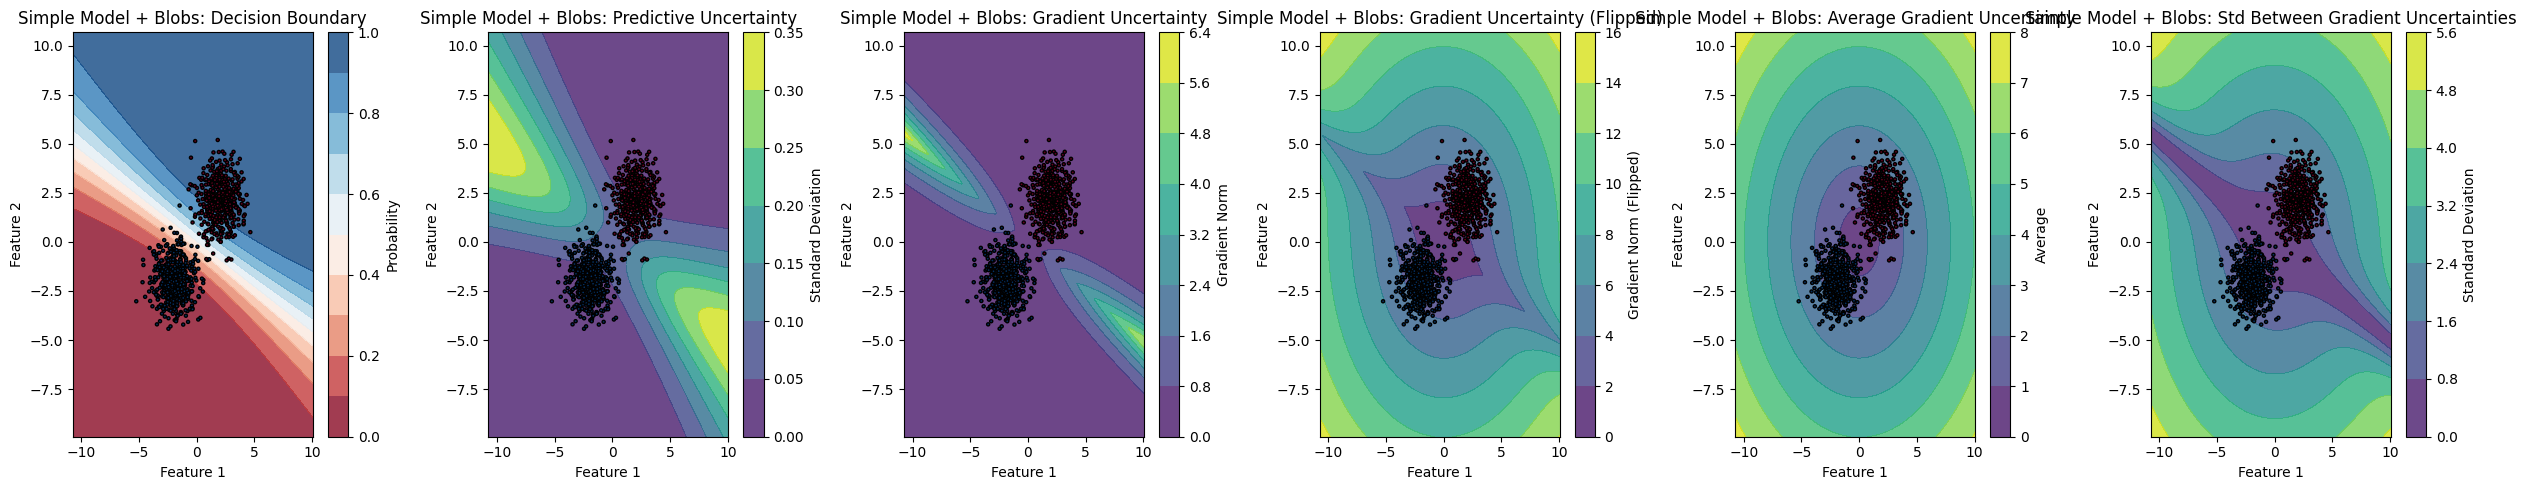

Correlation between Predictive Uncertainty and Gradient Uncertainty: 0.8361
Correlation between Predictive Uncertainty and Flipped Gradient: -0.1912
Correlation between Gradient and Flipped Gradient: -0.2973
Correlation between Average Gradient and Predictive Uncertainty: 0.0394
Correlation between Std Between Gradients and Predictive Uncertainty: -0.3776


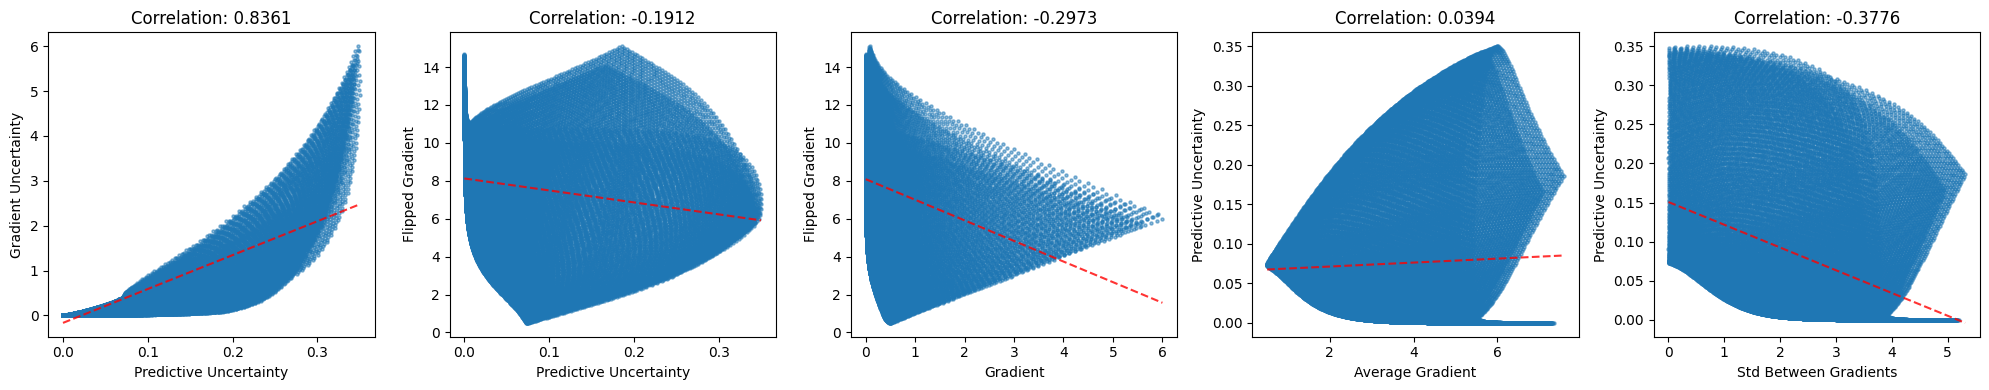

Average predictive uncertainty (Laplace): 0.0763
Average gradient uncertainty (same label): 0.4086
Average gradient uncertainty (flipped label): 7.6404
Average of gradient uncertainties: 4.0245
Average std between gradient uncertainties: 2.5568


In [43]:
# Experiment 1: Linearly separable blobs with a simple model
print("Experiment 1: Linear blobs with a simple model (Adam training)")
X_blobs, y_blobs = make_blobs(
    n_samples=1000, centers=[[-2, -2], [2, 2]], n_features=2, random_state=42
)
ex1 = run_experiment(
    X_blobs,
    y_blobs,
    SimpleModel,
    epochs=100,
    train_method="adam",
    title_prefix="Simple Model + Blobs: ",
)


Experiment 2: Moon dataset with a complex model
Epoch [100/1000], Loss: 0.2588
Epoch [200/1000], Loss: 0.2453
Epoch [300/1000], Loss: 0.1865
Epoch [400/1000], Loss: 0.1146
Epoch [500/1000], Loss: 0.0634
Epoch [600/1000], Loss: 0.0359
Epoch [700/1000], Loss: 0.0228
Epoch [800/1000], Loss: 0.0161
Epoch [900/1000], Loss: 0.0122
Epoch [1000/1000], Loss: 0.0097
Accuracy on entire dataset: 0.5000


/var/folders/f5/0n6l0yh12yggft3np84h1xxr0000gn/T/ipykernel_69099/2694630334.py:7: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1), np.arange(y_min, y_max, 0.1))


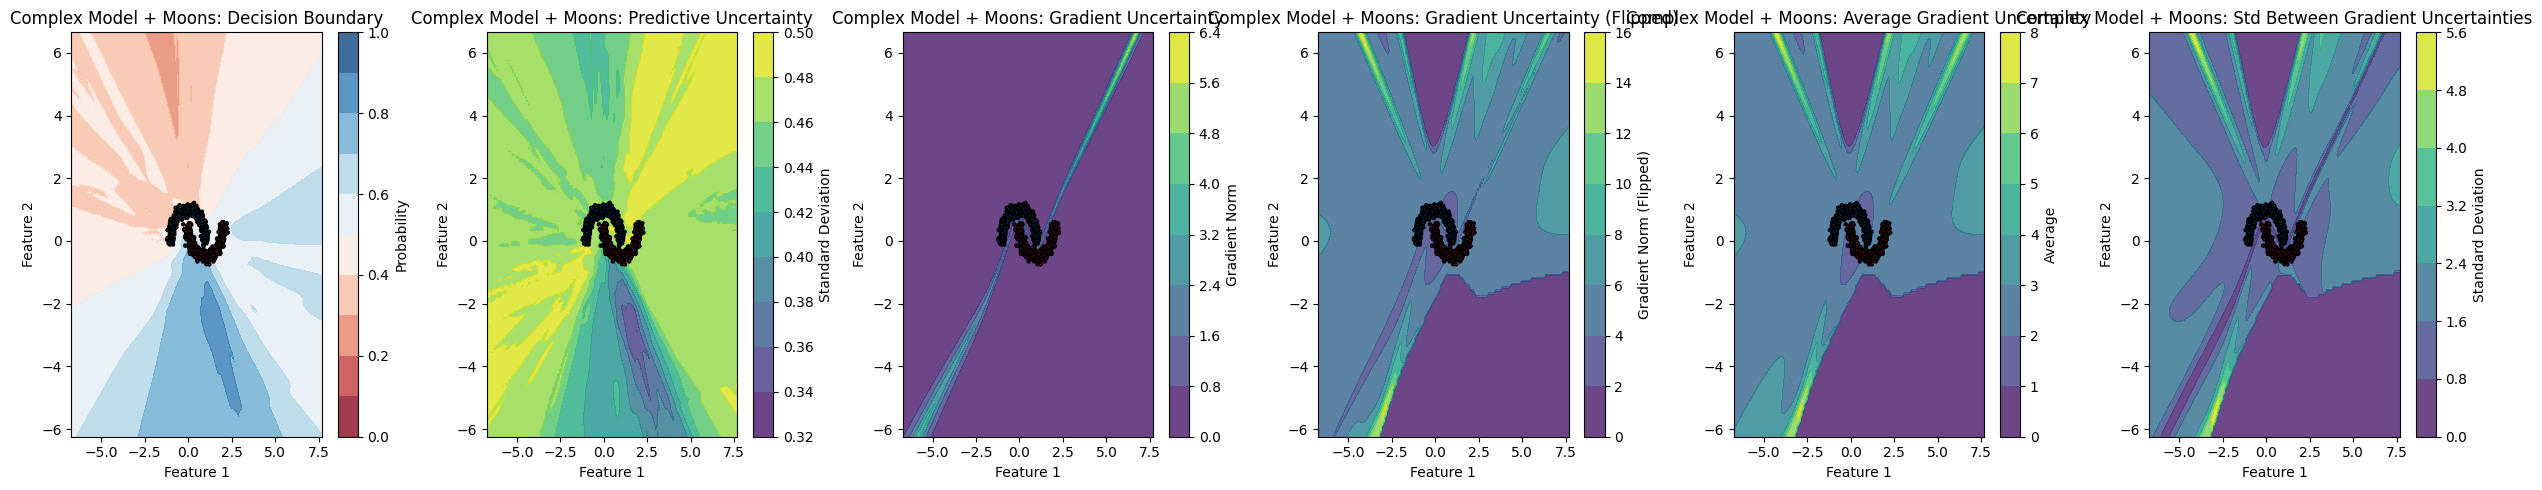

Correlation between Predictive Uncertainty and Gradient Uncertainty: 0.1926
Correlation between Predictive Uncertainty and Flipped Gradient: 0.5553
Correlation between Gradient and Flipped Gradient: 0.1190
Correlation between Average Gradient and Predictive Uncertainty: 0.5689
Correlation between Std Between Gradients and Predictive Uncertainty: 0.5231


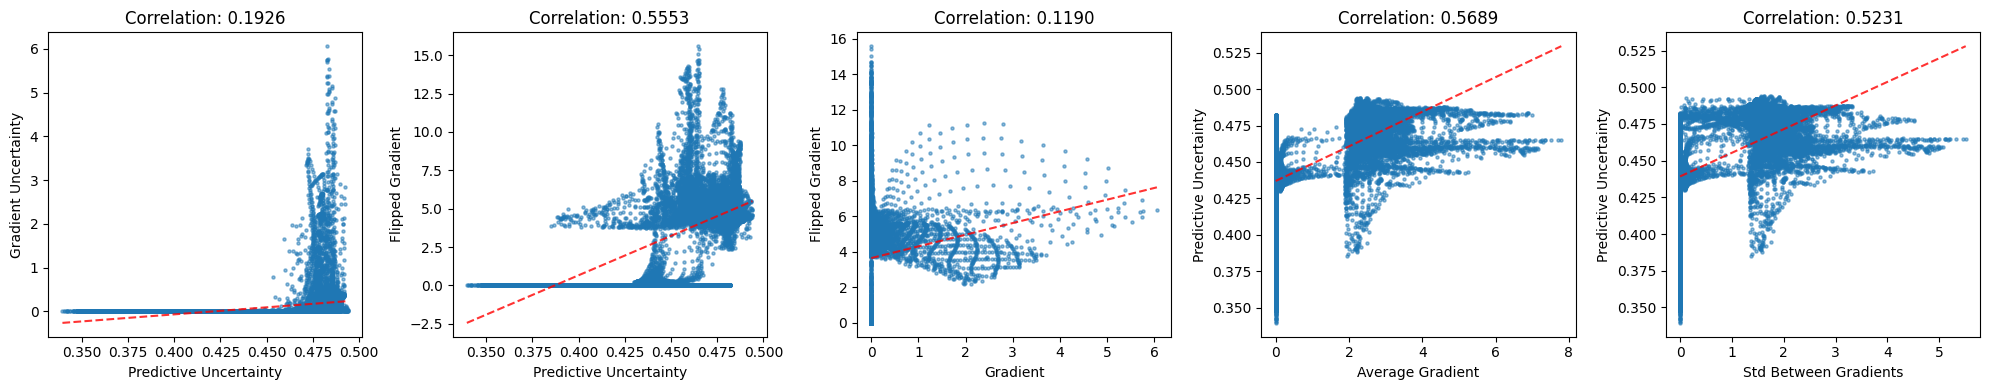

Average predictive uncertainty (Laplace): 0.4598
Average gradient uncertainty (same label): 0.1218
Average gradient uncertainty (flipped label): 3.7306
Average of gradient uncertainties: 1.9262
Average std between gradient uncertainties: 1.2759


In [44]:
# Experiment 2: Moon dataset with a complex model
print("\nExperiment 2: Moon dataset with a complex model")
X_moons, y_moons = make_moons(n_samples=1000, noise=0.1, random_state=42)
ex3 = run_experiment(
    X_moons,
    y_moons,
    ComplexModel,
    {"hidden_size": 32},
    epochs=1000,
    prior_precision=0.001,
    title_prefix="Complex Model + Moons: ",
)


=== Experiment 3: Blobs dataset with simple model (MCMC) ===
Pre-training model for MCMC initialization...
Epoch [20/100], Loss: 0.2098
Epoch [40/100], Loss: 0.1322
Epoch [60/100], Loss: 0.0955
Epoch [80/100], Loss: 0.0751
Epoch [100/100], Loss: 0.0621
Running NUTS MCMC sampler...


Sample: 100%|██████████| 600/600 [27:38,  2.76s/it, step size=1.60e-04, acc. prob=0.591]
/var/folders/f5/0n6l0yh12yggft3np84h1xxr0000gn/T/ipykernel_69099/1378130432.py:7: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1), np.arange(y_min, y_max, 0.1))


Accuracy on entire dataset: 0.5000


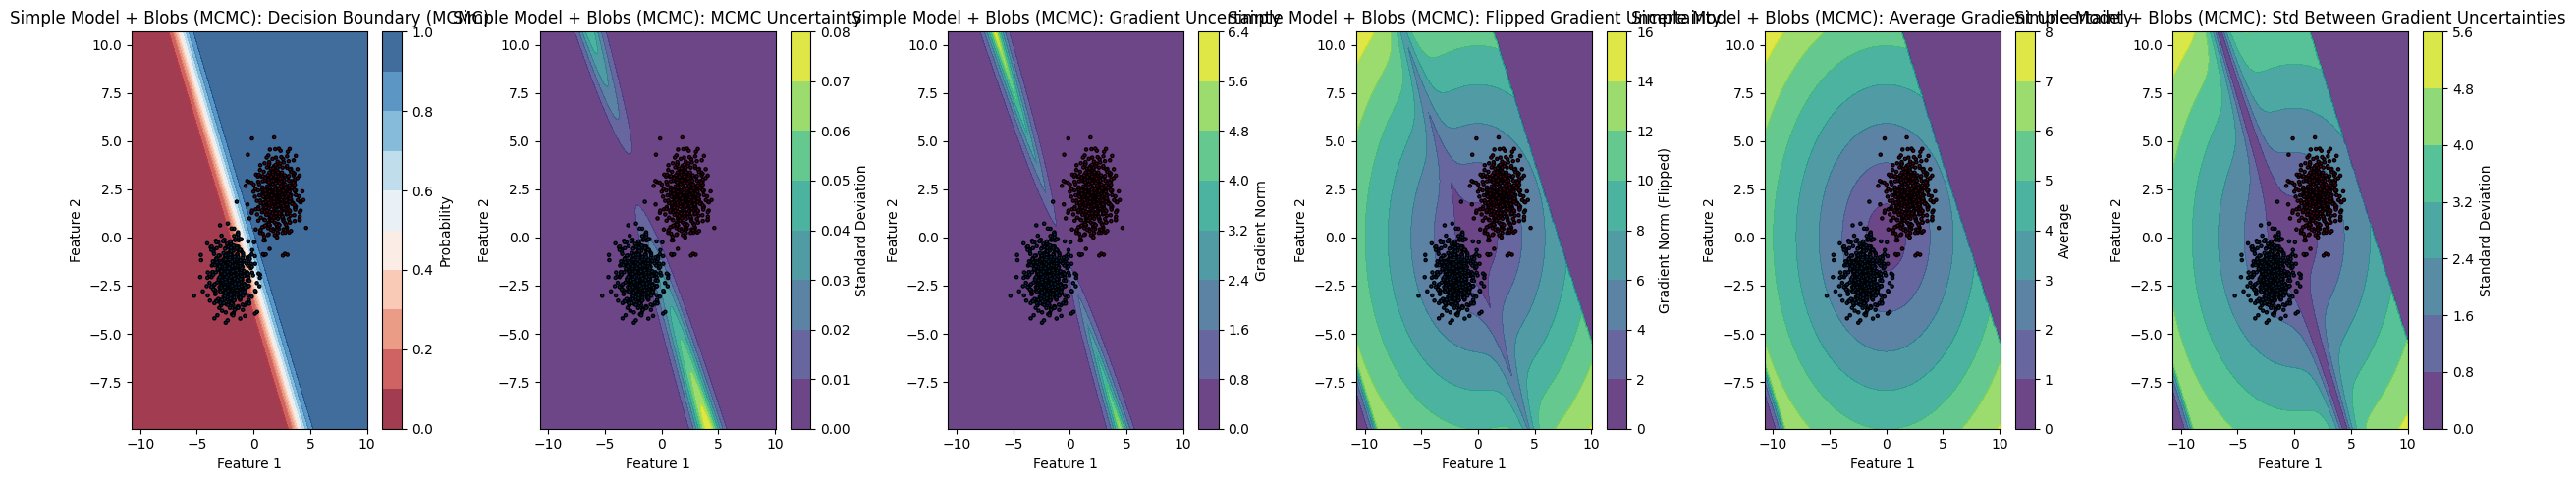

Correlation between MCMC Uncertainty and Gradient Uncertainty: 0.8133
Correlation between MCMC Uncertainty and Flipped Gradient: -0.0584
Correlation between Gradient and Flipped Gradient: -0.0360
Correlation between Average Gradient and MCMC Uncertainty: 0.0721
Correlation between Std Between Gradients and MCMC Uncertainty: -0.1859


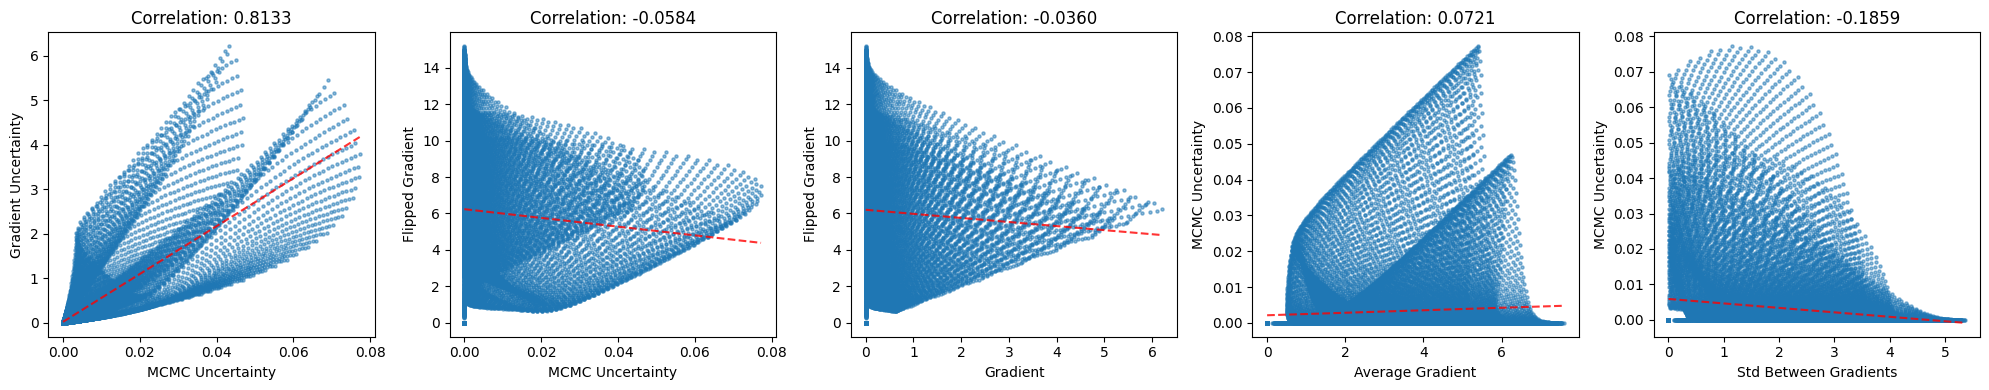

MCMC uncertainty (std): 0.0032
Gradient uncertainty (same label): 0.1973
Gradient uncertainty (flipped label): 6.1589
Average of gradient uncertainties: 3.1781
Average std between gradient uncertainties: 2.1077

Summary of all uncertainty measures:
  mcmc_std: 0.0032
  grad_same: 0.1973
  grad_flipped: 6.1589
  grad_avg: 3.1781
  grad_std: 2.1077
Blobs dataset results:
  Accuracy: 0.5000
  Average uncertainty (MCMC): 0.0032
  Gradient uncertainty (same label): 0.1973
  Gradient uncertainty (flipped label): 6.1589
  Average of gradient uncertainties: 3.1781
  Std between gradient uncertainties: 2.1077


In [45]:
# Experiment 3: MCMC on linearly separable blobs with simple model
print("\n=== Experiment 3: Blobs dataset with simple model (MCMC) ===")
blobs_model, blobs_results = run_mcmc_gradient_experiment(
    X_blobs,
    y_blobs,
    SimpleModel,
    prior_precision=0.01,
    num_samples=500,
    warmup_steps=100,
    title_prefix="Simple Model + Blobs (MCMC): ",
)

print(f"Blobs dataset results:")
print(f"  Accuracy: {blobs_results['accuracy']:.4f}")
print(f"  Average uncertainty (MCMC): {blobs_results['mcmc_std']:.4f}")
print(f"  Gradient uncertainty (same label): {blobs_results['grad_same']:.4f}")
print(f"  Gradient uncertainty (flipped label): {blobs_results['grad_flipped']:.4f}")
print(f"  Average of gradient uncertainties: {blobs_results['grad_avg']:.4f}")
print(f"  Std between gradient uncertainties: {blobs_results['grad_std']:.4f}")


=== Experiment 4: Moons dataset with complex model (MCMC) ===
Pre-training model for MCMC initialization...
Epoch [20/100], Loss: 0.5006
Epoch [40/100], Loss: 0.3713
Epoch [60/100], Loss: 0.3097
Epoch [80/100], Loss: 0.2719
Epoch [100/100], Loss: 0.2559
Running NUTS MCMC sampler...


Sample: 100%|██████████| 600/600 [32:59,  3.30s/it, step size=2.84e-04, acc. prob=0.540]
/var/folders/f5/0n6l0yh12yggft3np84h1xxr0000gn/T/ipykernel_69099/1378130432.py:7: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1), np.arange(y_min, y_max, 0.1))


Accuracy on entire dataset: 0.5000


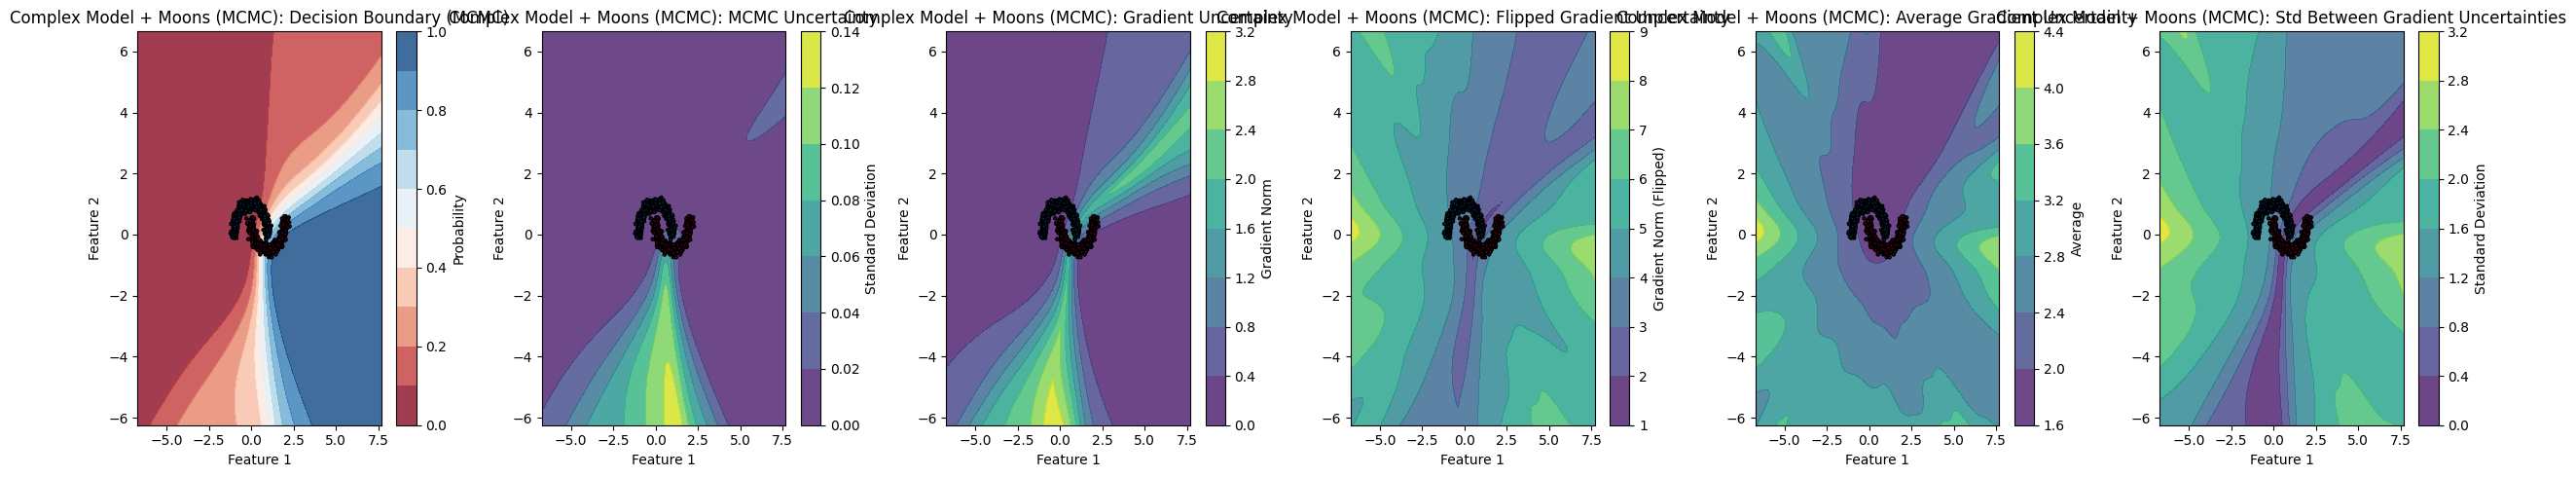

Correlation between MCMC Uncertainty and Gradient Uncertainty: 0.7591
Correlation between MCMC Uncertainty and Flipped Gradient: -0.3816
Correlation between Gradient and Flipped Gradient: -0.5759
Correlation between Average Gradient and MCMC Uncertainty: 0.0458
Correlation between Std Between Gradients and MCMC Uncertainty: -0.5747


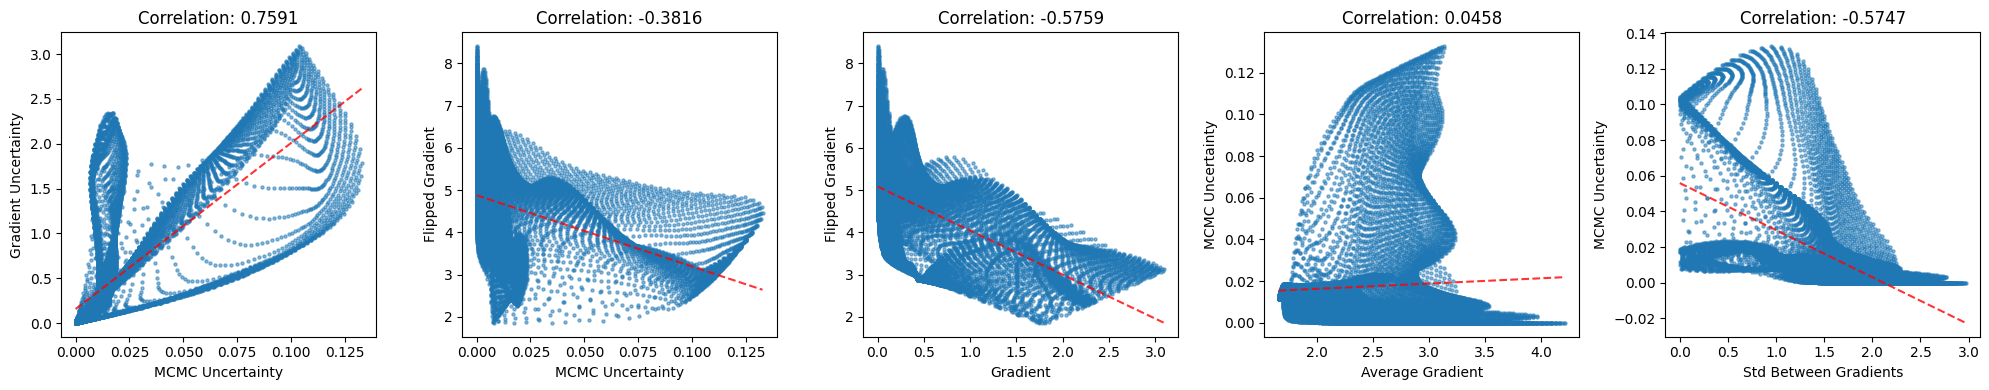

MCMC uncertainty (std): 0.0177
Gradient uncertainty (same label): 0.4839
Gradient uncertainty (flipped label): 4.5808
Average of gradient uncertainties: 2.5323
Average std between gradient uncertainties: 1.4485

Summary of all uncertainty measures:
  mcmc_std: 0.0177
  grad_same: 0.4839
  grad_flipped: 4.5808
  grad_avg: 2.5323
  grad_std: 1.4485
Moons dataset results:
  Accuracy: 0.5000
  Average uncertainty (MCMC): 0.0177
  Gradient uncertainty (same label): 0.4839
  Gradient uncertainty (flipped label): 4.5808
  Average of gradient uncertainties: 2.5323
  Std between gradient uncertainties: 1.4485


In [46]:
# Experiment 4: MCMC on Moon dataset with complex model
print("\n=== Experiment 4: Moons dataset with complex model (MCMC) ===")
moons_model, moons_results = run_mcmc_gradient_experiment(
    X_moons,
    y_moons,
    ComplexModel,
    {"hidden_size": 32},
    prior_precision=0.001,
    num_samples=500,
    warmup_steps=100,
    title_prefix="Complex Model + Moons (MCMC): ",
)

print(f"Moons dataset results:")
print(f"  Accuracy: {moons_results['accuracy']:.4f}")
print(f"  Average uncertainty (MCMC): {moons_results['mcmc_std']:.4f}")
print(f"  Gradient uncertainty (same label): {moons_results['grad_same']:.4f}")
print(f"  Gradient uncertainty (flipped label): {moons_results['grad_flipped']:.4f}")
print(f"  Average of gradient uncertainties: {moons_results['grad_avg']:.4f}")
print(f"  Std between gradient uncertainties: {moons_results['grad_std']:.4f}")